In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D

import scipy.linalg as linalg
from numpy.linalg import multi_dot
from numpy.linalg import norm
from numpy.random import normal as gau

import matplotlib 
matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
import math

import itertools
from scipy.spatial import ConvexHull ###Import the Convex hull construction function
from scipy.optimize import fsolve

from scipy.stats import bernoulli

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [51]:
# MULTIDIMENSIONAL FREE ENERGY, CHEMICAL POTENTIAL, AND OSMOTIC PRESSURE


def f(phi, kT, r, ki):

    if phi.ndim == 1:
        phi = np.append(phi, 1-np.sum(phi))
        return kT*( np.dot( np.log(phi)/r, phi ) ) + multi_dot([phi, ki, phi])/2
    
    
    out = np.zeros(len(phi))
    phi_w = np.ones((len(phi),1)) - np.sum(phi,axis = 1).reshape(len(phi),1)
    phi = np.hstack((phi,phi_w))
    
    for i,p in enumerate(phi):
        out[i] = kT*( np.dot( np.log(p)/r, p ) ) + multi_dot([p, ki, p])/2

    return out

def mu_exc(phi, kT, r, ki):
    
    if phi.ndim == 1:
        phi = np.append(phi, 1-np.sum(phi))
        return r[:-1]*( kT*( (1+ np.log(phi[:-1]) ) /r[:-1] - (1 + np.log(phi[-1]) )/r[-1] ) + np.dot(ki[:-1,:],phi) - np.dot(ki[-1,:],phi) )
    
    out = np.zeros_like(phi)
    phi_w = np.ones((len(phi),1)) - np.sum(phi,axis = 1).reshape(len(phi),1)
    phi = np.hstack((phi,phi_w))
    
    for i,p in enumerate(phi):
        out[i] =  r[:-1]*( kT*( (1+ np.log(p[:-1]) ) /r[:-1] - (1 + np.log(p[-1]) )/r[-1] ) + np.dot(ki[:-1,:],p) - np.dot(ki[-1,:],p) )  
    return out

def osm_p( phi, mu, kT, r, ki ):
    if phi.ndim == 1:
        return  -f(phi, kT, r, ki) + np.sum( phi/r[:-1]*mu  ) 
    
    out = np.zeros_like(phi)
    
    for i,p in enumerate(phi):
        out[i] = -f(p, kT, r, ki) + np.sum( p/r[:-1]*mu  ) 
    return out

In [52]:
def to_be_solved( var, phi_aver, kT, r, ki ):
    phi_I = var[:-1]
    frac_VI = var[-1]
    
    phi_II = (phi_aver - frac_VI * phi_I)/(1.-frac_VI)
    mu_I = mu_exc(phi_I, kT, r, ki)
    mu_II = mu_exc( phi_II , kT, r, ki)
    
    out = np.zeros_like(var)
    
    
    out[:-1] = mu_I - mu_II 
    out[-1] = osm_p(phi_I, mu_I,kT, r, ki) - osm_p(phi_II, mu_II, kT, r, ki)
    
    return out

In [53]:
#ARGS: NUMBER OF DIMENISIONS, MINIMUM ,MAXIMUM VALUES AND THE NUMBER OF VALUES OF THE MASS FRACTION FIELDS.
#RETURNS: AN nphi DIMENSIONAL ARRAY WITH THE COORDINATE OF POINTS ALLOWED BY INCOMPRESSIBILITY (I.E. LYING ON THE nphi-SIMPLEX)
def regular_grid( nphi, phi_min, phi_max, phi_points ):
        
    phis = []
    out = []
    
    span = np.linspace(phi_min,phi_max,phi_points)

    for index in itertools.product(span, repeat=nphi):
        cumul = np.sum(index) 
        if (cumul<1): 
            phis.append(index)
    
    phis = np.array(phis)
    
    for n in range(nphi):
        out.append(phis[:,n])
        
    if nphi ==1:
        out = phis.flatten()
    return np.array(out)

In [54]:
def hull_array( nphi, phis, fs ):
    
    #In the case n=1, we have to create an array with one element and fill it  
    if nphi==1:
        phis_new = np.zeros((1,phis.shape[0]))
        phis_new[0] = phis 
    else:
        phis_new = phis
    
    max_f = np.amax(fs)
    n_extra_slots = nphi+1
    
    hull=np.zeros((phis_new[0].shape[0] + n_extra_slots, nphi+1))
    
    origin = np.zeros(nphi)
    hull[0] = np.append( origin, max_f +1 ) 
    
    for count in range(nphi):

        vert = np.zeros(nphi)
        vert[count] = 1
        hull[count+1] = np.append( vert, max_f +1 ) 
    
    for n in range(nphi):
        hull[n_extra_slots:,n] = phis_new[n]
    
    hull[n_extra_slots:,-1] = fs

    return hull

In [55]:
def binodal(phi_stable, spacing):
    
    binod = []
    
    args=np.argsort(phi_stable)
    phi_stable_sorted = phi_stable[args]
    
    
    diff_indices=abs(phi_stable_sorted[1:]-phi_stable_sorted[:-1])
    
    if np.max(diff_indices) > spacing:
        amax = np.argmax(diff_indices)
        binod = np.append(phi_stable_sorted[amax], phi_stable_sorted[amax+1])
    
    return binod

In [56]:
# UNIDIMENSIONAL FREE ENERGY, CHEMICAL POTENTIAL, AND OSMOTIC PRESSURE, FOR THE PHASE DIAGRAM CORNERS

def f_1D( phi, kT, r, ki ):
    
    return kT/r[0]*phi*np.log(phi)  + kT*(1.-phi)*np.log(1.-phi) + ki[0,1]*phi*(1-phi) 

def mu_1D( phi, kT, r, ki ):
    
    return kT*(1+np.log(phi))  - r[0]*kT*(1 + np.log(1.-phi)) + ki[0,1]*(1-2*phi) 
    
def prepare_1D_corner(phi_min, phi_max, phi_points, 
                      kT, r, ki):
    
    spacing = 0.01
    
    grid = np.linspace(phi_min, phi_max, phi_points)
    
    #f calculated in the 1-dim subspace!
    f_grid = f_1D(grid, kT, r[np.array([0,-1])], ki[np.ix_([0,-1],[0,-1])])

    hull_input = hull_array( 1, grid, f_grid)
    convex = ConvexHull( hull_input, incremental=True )
    n_extra_slots = 1+1

    phi1, free_e, vertices = convex.points[n_extra_slots:,0],convex.points[n_extra_slots:,1],convex.vertices[n_extra_slots:]-n_extra_slots
    phi_stable, f_stable = phi1[vertices], free_e[vertices]

    return binodal(phi_stable, spacing)

In [57]:
#bin_pts are two M dimensional points belonging to the binodal, supposed to be close 
#to the m dimensional corner of the phase diagram. Will be used as initial guess.

#target is a point towards which the average of the binodal points will be pushed
#e.g. the center of the simplex or a critical point

def exploration_step(bin_pts, target, step, kT, r, ki):
    
    P= target
    A= bin_pts[0]
    B= bin_pts[-1]
    
    AP = P - A
    AB = B - A
    
    frac_VI = np.dot(AP, AB)/np.dot(AB,AB)
    
    H = A*(1 - frac_VI) + B*frac_VI
    
    HP = P - H  
    n = (HP) * step/np.linalg.norm(HP)
    
    phi_aver = H + n
    coeff = 0.25
    phi_I_guess = B + coeff*n
    
    x0 = np.append(phi_I_guess, frac_VI)
    x_roots = fsolve( lambda x : to_be_solved(x, phi_aver, kT, r, ki), x0)
    
    phi_I = x_roots[:-1]
    frac_VI = x_roots[-1]
    phi_II = (phi_aver - frac_VI * phi_I)/(1.-frac_VI)
    
    
    return np.array([phi_II, phi_aver, phi_I])

In [58]:
def exploration(bin_pts_sub, target, step, kT, r, ki):
    
    #to be deleted
    
    #dimension of the the full space
    M = len(r) - 1
    if bin_pts_sub.ndim == 1:
        bin_pts_sub = bin_pts_sub.reshape(2,1)
    
    #dimension of the projection (subspace) of the scaffolders
    m = len(bin_pts_sub[0])
    
    #to store phi_II, phi_aver, phi_I couples of M dimensional points
    set_phi = [] 
    
    #Now we embedd the point in the full space.
    phi_II = np.append(bin_pts_sub[0], np.zeros(M-m))
    phi_I = np.append(bin_pts_sub[-1], np.zeros(M-m))
    phi_aver = np.append(target[0:m], np.zeros(M-m))
    
    set_phi.append( np.array([phi_II, phi_aver, phi_I]) )
    
    while norm(target - set_phi[-1][1]) > 2*step:
        
        set_phi.append( exploration_step(set_phi[-1], target, step, kT, r, ki) )
    
    return np.array(set_phi)

In [59]:
def find_tl(dilute_b, dense_b, target):
    
    n_sc = len(dilute_b[0])
    proj_t = target[0:n_sc]
    
    dist_arr = np.zeros(len(dilute_b))
    for i in range(len(dilute_b)):
        dist_arr[i] = np.abs( np.cross( dense_b[i] - dilute_b[i], proj_t - dilute_b[i])/ norm(dense_b[i] - dilute_b[i])) 

    return np.array( [dilute_b[np.argmin(dist_arr)],dense_b[np.argmin(dist_arr)] ])

In [60]:
#The pool now is defined specifying the tie line it belongs 
#and the distance frac_VI_0 (between 0 and 1) from the dense boundary. 
#lamb is the constant fraction of the gel added in the batch

def select_same_pool( pool_tl, frac_VI_0, alpha, n_iter ):
    #phi_pool = pool_tl[0]*dist +(1-dist)*pool_tl[1]
    
    #phi_arr[0] = phi_pool
    
    #frac_VI_arr = np.zeros(n_iter+1)
    phi_arr = np.zeros((n_iter+1, len(pool_tl[0])))
    frac_VI_arr = np.zeros(n_iter+1)
    
    for n in range(n_iter+1):

        frac_VI = 1-(1-frac_VI_0)*(1-frac_VI_0*alpha)**n
        phi_arr[n] = pool_tl[1]*frac_VI +(1-frac_VI)*pool_tl[0]
        frac_VI_arr[n] = frac_VI
        
    return phi_arr, frac_VI_arr

In [61]:
def select_iter( pool_tl, frac_VI_0, alpha, n_iter ):
    
    phi_arr = np.zeros((n_iter+1, len(pool_tl[0])))
    frac_VI_arr = np.zeros(n_iter+1)
    
    frac_VI_arr[0] = frac_VI_0
    phi_arr[0] = pool_tl[1]*frac_VI_0 +(1-frac_VI_0)*pool_tl[0]
    
    for n in range(n_iter):

        frac_VI_arr[n+1] = frac_VI_arr[n]*(1- lamb*frac_VI_0) + alpha*frac_VI_0
        phi_arr[n+1] = pool_tl[1]*frac_VI_arr[n+1] +(1-frac_VI_arr[n+1])*pool_tl[0]
        
    return phi_arr, frac_VI_arr

In [62]:
def select( phi0, pool, set_phi, alpha, n_iter ):
    
    phi_arr = np.zeros((n_iter+1, len(phi0)))
    frac_VI_arr = np.zeros(n_iter+1)
    phi_arr[0] = phi0
    
    
    for n in range(n_iter):
        
        tl = find_tl(set_phi[:,0], set_phi[:,2], phi_arr[n])
        
        frac_VI = (phi_arr[n,0] - tl[0,0] )/(tl[1,0] - tl[0,0])
        frac_VI_arr[n] = frac_VI

        phi_arr[n+1] = tl[1]*frac_VI + (1-frac_VI)*(alpha*pool+(1-alpha)*tl[0])

    
    last_tl = find_tl(set_phi[:,0], set_phi[:,2], phi_arr[-1])
    frac_VI_arr[-1] = (phi_arr[-1,0] - tl[0,0] )/(last_tl[1,0] - tl[0,0])
        
    return phi_arr, frac_VI_arr 

In [63]:
def _rect_inter_inner(x1,x2):
    n1=x1.shape[0]-1
    n2=x2.shape[0]-1
    X1=np.c_[x1[:-1],x1[1:]]
    X2=np.c_[x2[:-1],x2[1:]]
    S1=np.tile(X1.min(axis=1),(n2,1)).T
    S2=np.tile(X2.max(axis=1),(n1,1))
    S3=np.tile(X1.max(axis=1),(n2,1)).T
    S4=np.tile(X2.min(axis=1),(n1,1))
    return S1,S2,S3,S4

def _rectangle_intersection_(x1,y1,x2,y2):
    S1,S2,S3,S4=_rect_inter_inner(x1,x2)
    S5,S6,S7,S8=_rect_inter_inner(y1,y2)

    C1=np.less_equal(S1,S2)
    C2=np.greater_equal(S3,S4)
    C3=np.less_equal(S5,S6)
    C4=np.greater_equal(S7,S8)

    ii,jj=np.nonzero(C1 & C2 & C3 & C4)
    return ii,jj

def intersection(x1,y1,x2,y2):

    ii,jj=_rectangle_intersection_(x1,y1,x2,y2)
    n=len(ii)

    dxy1=np.diff(np.c_[x1,y1],axis=0)
    dxy2=np.diff(np.c_[x2,y2],axis=0)

    T=np.zeros((4,n))
    AA=np.zeros((4,4,n))
    AA[0:2,2,:]=-1
    AA[2:4,3,:]=-1
    AA[0::2,0,:]=dxy1[ii,:].T
    AA[1::2,1,:]=dxy2[jj,:].T

    BB=np.zeros((4,n))
    BB[0,:]=-x1[ii].ravel()
    BB[1,:]=-x2[jj].ravel()
    BB[2,:]=-y1[ii].ravel()
    BB[3,:]=-y2[jj].ravel()

    for i in range(n):
        try:
            T[:,i]=np.linalg.solve(AA[:,:,i],BB[:,i])
        except:
            T[:,i]=np.NaN


    in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)

    xy0=T[2:,in_range]
    xy0=xy0.T
    return np.array(xy0[:,0]),np.array(xy0[:,1])


In [64]:
def build_p(f, blocky):
    pAA = f*(1-blocky) + blocky 
    pBB = f*(blocky-1) + 1
    
    p = np.zeros((2,2))
    p[0,0] = pAA
    p[0,1] = 1 - pBB
    p[1,0] = 1 - pAA
    p[1,1] = pBB
    
    return p

In [65]:
def chain(f, blocky, l):
    long_seq = np.zeros(l)
    
    if f < -blocky/(1-blocky) or f > -1/(blocky-1):
        print('Parameters inconsistent')
        long_seq = np.full(l,np.nan)
        
    elif blocky == 1:
        long_seq[:int(l/2)] = 1
    
    elif blocky == -1:
        long_seq[1::2] = 1
    
    else:
        
        long_seq[0] = int( f + 0.5)
        
        p = build_p(f,blocky)

        for i in range(1,l):
            long_seq[i] = int(bernoulli.rvs( p[1,int(long_seq[i-1])] ) )

    
    return long_seq

In [66]:
def possible_seq(n_seq, directed=False):

    alphabet = np.array([0,1])

    #COULD BE IMPROVED USING MESHGRID + TILE
    seq = np.array(list(itertools.product(alphabet, repeat=n_seq)))
    
    if directed:
        seq_reduced = seq
        
    else:
        seq_reduced = [seq[0]]

        for s in seq[1:]:
            #SCAN IN THE SEQUENCES ALREADY COLLECTED TO LOOK FOR A COPY
            copy=False
            for i_r, s_r in enumerate(seq_reduced):

                if (s==s_r[::-1]).all() == True :
                    copy = True
                    break

            if copy == False:
                seq_reduced.append(s)
    
    s_char = []
    for s in seq_reduced:
        s_char.append(str(s)[1:-1])
    
    return np.array(seq_reduced), np.array(s_char)

In [67]:
def histo_sequences(long_seq , seq_list, directed=False):
    
    
    M = len(seq_list)
    l_seq = len(seq_list[0])
    n_samples = int(len(long_seq)/l_seq)
    
    chop_chain = long_seq.reshape((n_samples, l_seq))
    counts = np.zeros(M)
    
    for s in chop_chain:
        
        for ind, s_l in enumerate(seq_list):
            
            if (not directed) and ( (s==s_l).all() or (s==s_l[::-1]).all() ):
                counts[ind] = counts[ind] + 1
                break
            elif directed and (s==s_l).all() :
                counts[ind] = counts[ind] + 1
                break
    
    freq = counts/n_samples
    
    return freq

In [68]:
# Python3 implementation of Finding 
# Length of Longest Common Substring 

# Returns length of longest common 
# substring of X[0..m-1] and Y[0..n-1] 
def LCSubStr(X, Y): 
    
    m=X.shape[0]
    n=Y.shape[0]

    LCSuff = [[0 for k in range(n+1)] for l in range(m+1)] 

    result = 0

    # Following steps to build 
    # LCSuff[m+1][n+1] in bottom up fashion 
    for i in range(m + 1): 
        for j in range(n + 1): 
            if (i == 0 or j == 0): 
                LCSuff[i][j] = 0
            elif (X[i-1] == Y[j-1]): 
                LCSuff[i][j] = LCSuff[i-1][j-1] + 1
                result = max(result, LCSuff[i][j]) 
            else: 
                LCSuff[i][j] = 0
    return result 

In [69]:
def Int_Mat(seq, directed=False):
    
    dim = seq.shape[0]
    out = np.zeros((dim,dim))
    
    #COMPARING ALL THE SEQUENCES
    for j, seq1 in enumerate(seq):
        for i, seq2 in enumerate(seq[:j+1]):

            seq2_compl = 1.-seq2
            
            if directed:
                out[i,j] =LCSubStr(seq1,seq2_compl[::-1])
                
            else:
                out[i,j] = max(LCSubStr(seq1,seq2_compl), LCSubStr(seq1,seq2_compl[::-1]))

            out[j,i] = out[i,j]
    
            
    return -out

In [70]:
c1 = (132/255, 197/255, 97/255) # green
c2 = (223/255, 184/255, 88/255) # yellow

def make_graph_pretty(xlab=False, ylab=False, ax = False, eq=False, 
                      fs = 15, lp_x=10, lp_y=10, loc=0, markerfirst=True, handlelength=None):
    
    color1 = 'black'#'darkorange'
    color2 = (0, 0, 0)
    color2 = (1, 1, 1)
    
    if ax == False:
        ax = plt.gca()

    if eq:    
        ax.set_aspect('equal')
    else:
        ax.set_aspect(1./ax.get_data_ratio())
        
    ax.tick_params(axis='x', colors=color1, which='both')
    ax.tick_params(axis='y', colors=color1, which='both')
    

    hfont = {'fontname':'Helvetica'}
    
    if xlab:
        ax.set_xlabel(xlab, color=color1, labelpad = lp_x, fontsize = fs, **hfont)
    if ylab:
        ax.set_ylabel(ylab, color=color1 , labelpad = lp_y, fontsize = fs)
    ax.spines['left'].set_color(color1)
    ax.spines['bottom'].set_color(color1)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_facecolor(color2)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    
    plt.gcf().subplots_adjust(bottom=0.17, left=0.15)
    plt.legend(frameon=False, loc=loc, labelspacing=0.1,
               markerfirst=markerfirst, handlelength=handlelength)

In [71]:
def heatmap(data, row_labels, col_labels, tick_siz = None, ax=None,
            cbar_kw={}, cbarlabel="", lab_siz = None, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", 
                       fontsize=lab_siz )

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=tick_siz)
    ax.set_yticklabels(row_labels, fontsize=tick_siz)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# Produce data for Figure 1

In [31]:
#n of component (water excluded!!)
M = 2

#vector of molecular volumes in units of the smallest (nu_water)
r = np.ones(M+1) #for now all equals!
kT = 1.

b= -0.


e = np.array([-3.,      -0.8,      0, 
               0,       -0.8,       0,
               0,        0,          0  ]).reshape(M+1,M+1)

ki = np.zeros_like(e)

for i in range(M+1):
    for j in range(i):
        e[i,j] = e[j,i]
        ki[i,j] = ki[j,i] = (2*e[i,j] - e[i,i] - e[j,j])

In [32]:
ki

array([[0. , 2.2, 3. ],
       [2.2, 0. , 0.8],
       [3. , 0.8, 0. ]])

In [33]:
phi_min, phi_max, n_points = 1.e-6, 1.- 1.e-6 , 499 #999

phi_grid = regular_grid(M, phi_min, phi_max, n_points)
f_grid = f(phi_grid.transpose(), kT, r, ki)


hull_input = hull_array( M, phi_grid, f_grid)
convex = ConvexHull( hull_input, incremental=True )
n_extra_slots = M+1
        
phi1, phi2 , free_e, vertices = convex.points[n_extra_slots:,0],convex.points[n_extra_slots:,1],convex.points[n_extra_slots:,2],convex.vertices[n_extra_slots:]-n_extra_slots
phi1_stable,phi2_stable,f_stable=phi1[vertices],phi2[vertices],free_e[vertices]

bin_mask, xedges, yedges = np.histogram2d(phi1_stable, phi2_stable, bins =int(n_points+1))

In [34]:
phi_min, phi_max, n_points = 1.e-5, 1.- 1.e-5 , 199

bin_pts = prepare_1D_corner(phi_min, phi_max, n_points, kT, r, ki)
print(bin_pts)

#d = 0.05
#target = np.append(phi_av_sc, np.ones(M-1)*phi_av_cl )
target = np.array([0.5,0.5])
set_phi = exploration(bin_pts, target, 0.0005, kT, r, ki)

[0.07071566 0.92928434]


In [35]:
phi0_same = np.array([0.175,0.175])
alpha = 1

#WE CHOSE THE POOL TO COINCIDE WITH THE TARGET!
pool_tl = find_tl(set_phi[:,0], set_phi[:,2], phi0_same)
print(pool_tl)

#Initial frac of gel:
frac_VI = norm(phi0_same - pool_tl[0])/norm(pool_tl[1] - pool_tl[0])
#Time scale of the decayment to the gel point
tau = 1/np.log(1/(1-alpha*frac_VI))


n = 40
print(frac_VI, n)

[[0.10400636 0.18736912]
 [0.87418569 0.05315076]]
0.0921774373999819 40


In [36]:
phi_arr_same, vol_arr_same = select_same_pool(pool_tl, frac_VI, alpha, n)

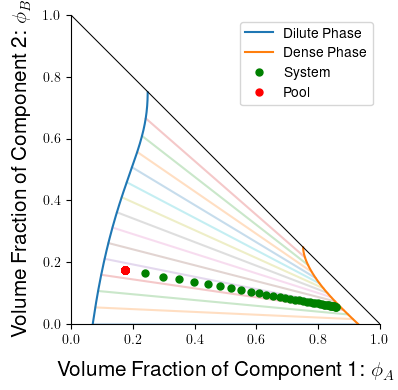

In [40]:
n_it = len(set_phi)
stride = 70
for i in range(int(n_it/stride)):
    plt.plot( set_phi[i*stride,:,0] , set_phi[i*stride,:,1], alpha = 0.25 )

dil = plt.plot( set_phi[:,0,0], set_phi[:,0,1], c = '#1f77b4', label='Dilute Phase' ) 
dens = plt.plot( set_phi[:,-1,0], set_phi[:,-1,1], c= '#ff7f0e', label='Dense Phase')

plt.plot([0,1], [1,0], c= 'k', linewidth=0.75)

x_label= r'Volume Fraction of Component 1: $\phi_A$'
y_label= r'Volume Fraction of Component 2: $\phi_B$'

make_graph_pretty(x_label, y_label)

ax = plt.gca()
ax.set_aspect(1./ax.get_data_ratio())

plt.xlim(0,1)
plt.ylim(0,1)

for j in range( n ):
    
    sys = plt.plot(phi_arr_same[j,0], phi_arr_same[j,1], '.', c = 'g',markersize = 10 , label='System' )
    pool = plt.plot(phi_arr_same[0,0], phi_arr_same[0,1], '.', c = 'r', markersize = 10, label='Pool')
    if j==0:
        plt.legend()
    
plt.tight_layout()
    
plt.show()

In [41]:
####################################
alpha = .5

pool = np.copy(phi0_same)
phi0 = np.array([0.4,0.5])
####################################

phi_arr, vol_arr = select(phi0, pool, set_phi, alpha, n)

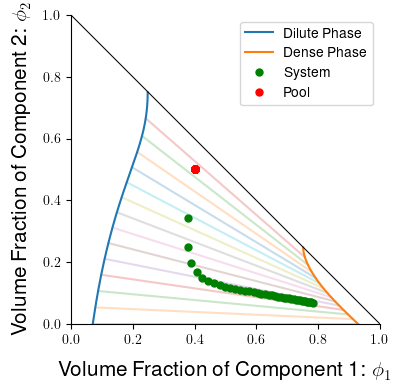

In [43]:
n_it = len(set_phi)
stride = 70
for i in range(int(n_it/stride)):
    plt.plot( set_phi[i*stride,:,0] , set_phi[i*stride,:,1], alpha = 0.25 )

dil = plt.plot( set_phi[:,0,0], set_phi[:,0,1], c = '#1f77b4', label='Dilute Phase' ) 
dens = plt.plot( set_phi[:,-1,0], set_phi[:,-1,1], c= '#ff7f0e', label='Dense Phase')

plt.plot([0,1], [1,0], c= 'k', linewidth=0.75)

x_label= r'Volume Fraction of Component 1: $\phi_1$'
y_label= r'Volume Fraction of Component 2: $\phi_2$'

make_graph_pretty(x_label, y_label)

ax = plt.gca()
ax.set_aspect(1./ax.get_data_ratio())

plt.xlim(0,1)
plt.ylim(0,1)

for j in range( n ):
    
    plt.plot(phi_arr[j,0], phi_arr[j,1], '.', c = 'g',markersize = 10 , label='System' )
    plt.plot(phi_arr[0,0], phi_arr[0,1], '.', c = 'r', markersize = 10, label='Pool')
    if j==0:
        plt.legend()
    
plt.tight_layout()
plt.show()

# Produce data for fig 1 and SI

In [44]:
dire = False
fold = '../input_folder/'

n_basis = 4

seq, seq_char = possible_seq(n_basis, dire)
seq_char= np.append(seq_char,'W')

M = len(seq)

e_DNA = Int_Mat(seq, dire)
e = np.zeros((M+1, M+1))
e[:-1,:-1] = e_DNA

ki = np.zeros_like(e)

for i in range(M+1):
    for j in range(i):
        e[i,j] = e[j,i]
        ki[i,j] = ki[j,i] = (2*e[i,j] - e[i,i] - e[j,j])

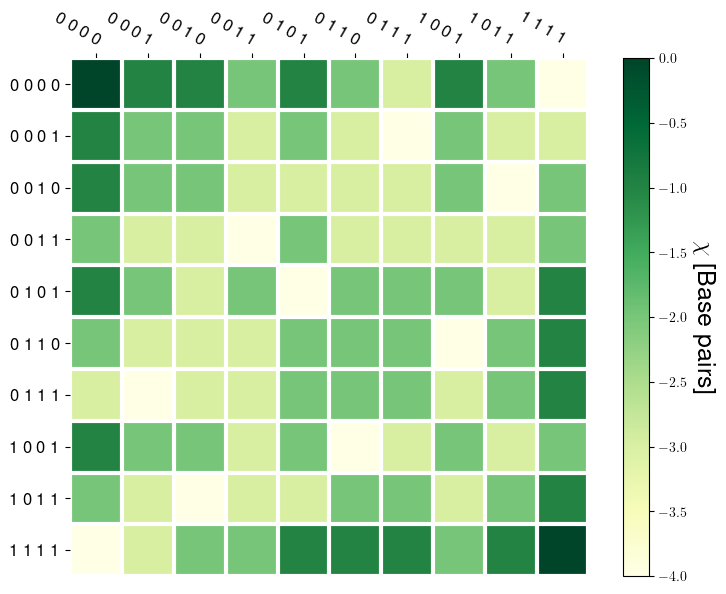

In [45]:
fig, ax = plt.subplots(1,1,figsize=(9,7))
fig.subplots_adjust(top=0.85)
im, cbar = heatmap(e[:-1,:-1], seq_char[:-1], seq_char[:-1], tick_siz = 12, ax=ax,
        cmap="YlGn", cbarlabel= r'$\chi$ [Base pairs]', lab_siz= 18)

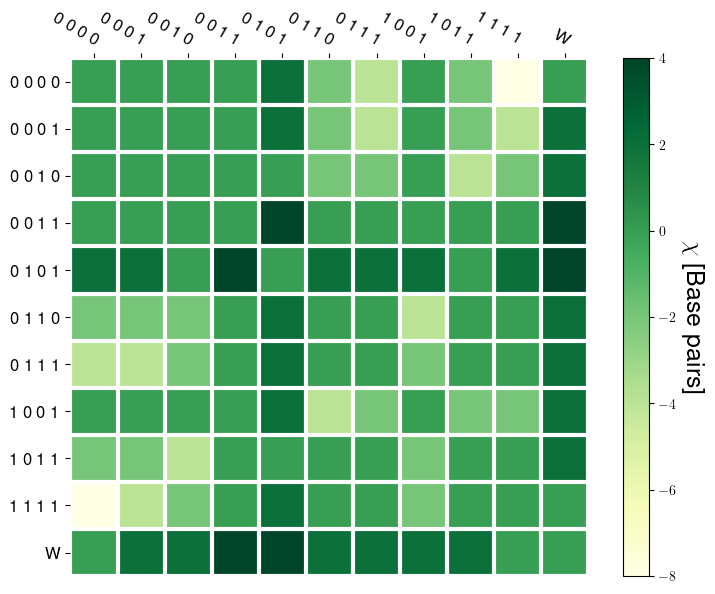

In [46]:
fig, ax = plt.subplots(1,1,figsize=(9,7))
fig.subplots_adjust(top=0.85)
im, cbar = heatmap(ki, seq_char, seq_char, tick_siz = 12, ax=ax,
        cmap="YlGn", cbarlabel= r'$\chi$ [Base pairs]', lab_siz= 18)


In [26]:
np.savetxt(fold+'ki.txt', ki.astype(int), fmt='%i')
np.savetxt(fold+'e.txt', e.astype(int), fmt='%i')
np.savetxt(fold+'labels.txt', seq_char[:-1], fmt="%s")

In [39]:
#Relative abundance of SEQUENCES
#chain_l = 500
chain_l = 50000

frac_min = 0.2
n_frac = 13 

# blocky_min = -0.9
# n_blocky = 11

blocky_min = -0.9
n_blocky = 13


frac_range = np.linspace(frac_min, 1-frac_min, n_frac)
blocky_range = np.linspace(blocky_min, -blocky_min, n_blocky)


frac_arr = []
block_arr = []

print(frac_range, blocky_range)
np.savetxt(fold+'ranges.txt', np.array([[frac_min, n_frac], [blocky_min, n_blocky]]))

[0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8 ] [-9.00000000e-01 -7.50000000e-01 -6.00000000e-01 -4.50000000e-01
 -3.00000000e-01 -1.50000000e-01 -1.11022302e-16  1.50000000e-01
  3.00000000e-01  4.50000000e-01  6.00000000e-01  7.50000000e-01
  9.00000000e-01]


In [41]:
#zer_tol = 0.0001

frac_range = [0.5]
blocky_range = [-0]

for f in frac_range:
    for b in blocky_range:
        
        if f < -b/(1-b) or f > -1/(b-1):
            continue
        
        l = M*n_basis*chain_l

        long_seq = chain(f, b, l)
        freq = histo_sequences(long_seq, seq, directed=dire)
        
        block_arr.append(b)
        frac_arr.append(f)
        
        
        b_form = "{:.2f}".format(b)
        f_form = "{:.2f}".format(f)
        
#         if dire and np.abs(b)<zer_tol and np.abs(f-0.5)<zer_tol:
#             freq = np.ones(M)/M
        
        print('Processing b: ' + b_form +'f :'+f_form )
        print(freq)
        np.savetxt(fold+'b_'+b_form+'_f_'+f_form+'.txt', freq)

 

Processing b: 0.00f :0.50
[0.062474 0.124704 0.124968 0.125258 0.125018 0.062484 0.125192 0.062732
 0.124998 0.062172]


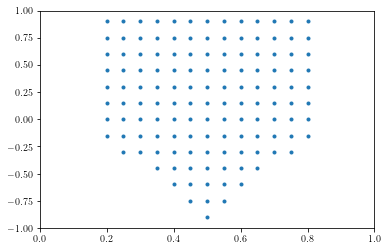

In [28]:
plt.plot(frac_arr, block_arr, '.')
plt.xlim([0,1])
plt.ylim([-1,1])
plt.show()